In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [40]:
vacancies = pd.read_csv('vacancies.csv')

In [4]:
vacancies.drop('Unnamed: 0', inplace=True, axis=1)

In [6]:
vacancies_copy = vacancies.copy()

In [3]:
vacancies['industry']

0           ['Рабочий персонал', 'Транспорт, логистика']
1                               ['Транспорт, логистика']
2           ['Рабочий персонал', 'Транспорт, логистика']
3                                            ['Продажи']
4           ['Рабочий персонал', 'Транспорт, логистика']
                             ...                        
503                           ['Медицина, фармацевтика']
504    ['Продажи', 'Строительство, недвижимость', 'Ко...
505                             ['Транспорт, логистика']
506     ['Информационные технологии, интернет, телеком']
507                             ['Транспорт, логистика']
Name: industry, Length: 508, dtype: object

In [7]:
import re
'''Создаем DataFrame для хранения фиктивных переменных для каждой отрасли по всем вакансиям'''
# Создаем итератор по всем отраслям
industry_iter = (set(re.findall(r"'(.+?)'", x)) for x in vacancies['industry'])
# Оставляем только уникальные отрасли
industries = sorted(set.union(*industry_iter))
industry_dummies = pd.DataFrame(np.zeros((len(vacancies), len(industries))), columns=industries)
for i, gen in enumerate(vacancies.industry):
    industry_dummies.loc[i, re.findall(r"'(.+?)'", gen)] = 1

In [8]:
vacancies_copy = pd.concat([vacancies_copy, industry_dummies], axis=1)
vacancies_copy.drop('industry', axis=1, inplace=True)

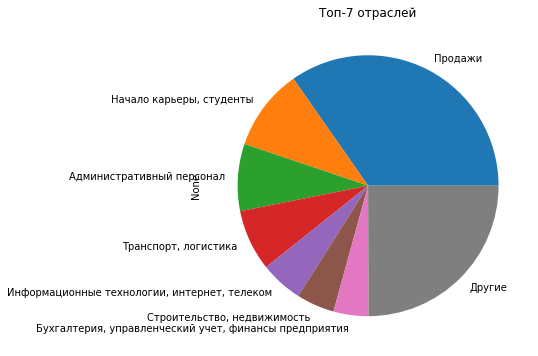

In [9]:
'''Построение круговой диаграммы'''
# Считаем количество вакансий на топ-7 отраслей и остальные
industry_counts = industry_dummies.sum(axis=0).sort_values(ascending=False)
top_seven_counts = industry_counts[:7]
others_counts = np.sum(industry_counts[7:])
industry_counts = top_seven_counts.append(pd.Series([others_counts], index =['Другие']))
# Используем полученный Series для построения диаграммы
industry_counts.plot(kind='pie', figsize=(10, 6))
plt.title("Топ-7 отраслей")
plt.show()

In [10]:
def clean_exp(exp):
    try:
        years = re.findall('[0-9]+', exp)
        exp_cleaned = 0
        if len(years) == 1:
            exp_cleaned = int(years[0])
        elif len(years) == 2:
            exp_cleaned = (int(years[0]) + int(years[1])) / 2
    except:
        return
    return exp_cleaned  

In [11]:
def clean_salary(sal):
    if type(sal) == float:
        pass
    else:
        sal = sal.split()
        sal = ''.join(sal)
        sals = re.findall('[0-9]+', sal)
        if len(sals) == 1:
            sal_cleaned = int(sals[0])
        elif len(sals) == 2:
            sal_cleaned = (int(sals[0]) + int(sals[1])) / 2
        return sal_cleaned

In [12]:
# Очищаем и преобразовываем данные 
vacancies_copy['skills'] = vacancies_copy['skills'].str.lower()
vacancies_copy['experience'] = vacancies_copy['experience'].apply(clean_exp) 
vacancies_copy['salary'] = vacancies_copy['salary'].apply(clean_salary) 

In [72]:
vacancies_copy.isna().sum()

location                                                   0
experience                                                 0
skills                                                   159
salary                                                     0
Автомобильный бизнес                                       0
Административный персонал                                  0
Банки, инвестиции, лизинг                                  0
Безопасность                                               0
Бухгалтерия, управленческий учет, финансы предприятия      0
Высший менеджмент                                          0
Добыча сырья                                               0
Закупки                                                    0
Инсталляция и сервис                                       0
Информационные технологии, интернет, телеком               0
Искусство, развлечения, масс-медиа                         0
Консультирование                                           0
Маркетинг, реклама, PR  

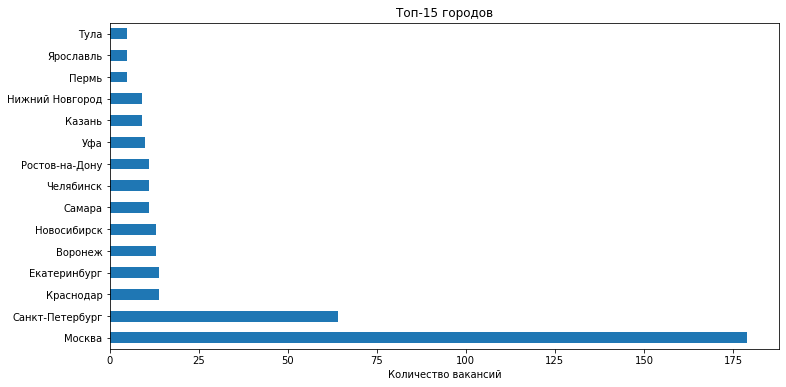

In [13]:
plt.figure(figsize=(12,6))
vacancies_copy["location"].value_counts().nlargest(15).plot(kind='barh')
plt.title('Топ-15 городов')
plt.xlabel('Количество вакансий')
plt.show()

C:\Users\79279\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 1.0, 'Плотность распределения заработной платы')

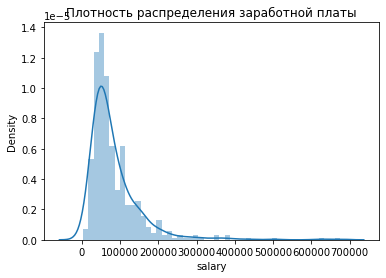

In [14]:
import seaborn as sns
# Построим гистограмму и график плотности распределения ЗП
sns.distplot(a=vacancies_copy['salary'])
plt.title("Плотность распределения заработной платы")

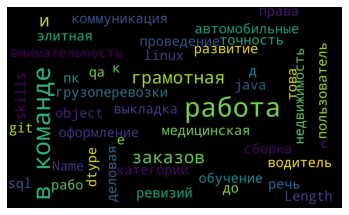

In [15]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def wordcloud(data):
    wordcloud = WordCloud(background_color = 'Black',width=500, height=300,
                         max_words = 50,
                         max_font_size = 40,
                         scale = 5,
                         random_state = 5).generate(str(data))
    
    plt.imshow(wordcloud)
    plt.axis('off')
wordcloud(vacancies_copy["skills"].dropna())

In [18]:
def geocode(driver, location):
    '''Возвращает географические кооординаты соответсвующего населенного пункта'''
    # Заполняем строку поиска 
    WebDriverWait(driver,100).until(EC.presence_of_element_located((By.TAG_NAME,'body')))
    searchbox = driver.find_element(By.ID, 'searchboxinput')
    searchbox.send_keys(location)
    # Кликаем на кнопку поиска
    submit = WebDriverWait(driver,15).until(EC.element_to_be_clickable(('id','searchbox-searchbutton')))
    submit.click()
    # Ждем пока страница обновится
    try:
        element_present = EC.presence_of_element_located((By.CLASS_NAME,'x3AX1-LfntMc-header-title'))
        WebDriverWait(driver, 10).until(element_present)
    except:
        pass
    # Получаем текущую ссылку и извлекаем из нее координаты
    cur_url = driver.current_url
    lat = re.search('(?<=@)\d{1,3}\.\d{4,}', cur_url).group()
    lng = re.search('(?<=,)\d{1,3}\.\d{4,}', cur_url).group()
    # Очищаем поле поиска
    searchbox.clear()
    return lat, lng

In [23]:
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
import time
'''Кодирование названия города в его координаты'''
service = Service("C:\Program Files (x86)\Google\Chrome\Application\chromedriver_win64\chromedriver.exe")
# Инициализация WebDriver и переходит на страницу Гугл-карты
driver = webdriver.Chrome(service=service)                                       
driver.get("https://www.google.co.in/maps/@10.8091781,78.2885026,7z")
time.sleep(5)
# Инициализируем списки координат долготы и широты
locations = vacancies_copy['location'].values
lats = np.array([None] * len(vacancies))
lngs = lats.copy()
unique_locations = np.unique(locations[~ pd.isnull(locations)])

# Итерируем по массиву городов и заполняем соответствующие координаты
for loc in unique_locations:
    lats[locations == loc], lngs[locations == loc] = geocode(driver, loc) 
# Завершаем работу с браузером
driver.quit()

In [24]:
vacancies_copy['latitude'] = lats.astype(float)
vacancies_copy['longitude'] = lngs.astype(float)

In [26]:
vacancies_copy.drop('location', axis=1, inplace=True)

Text(0.5, 1.0, 'Координаты')

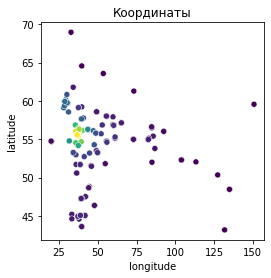

In [25]:
from scipy import stats
'''
Построение точечного графика координат, включая цветовой индикатор 
встречаемости в вакансиях
'''
values = np.matrix([vacancies_copy["longitude"], vacancies_copy["latitude"]], dtype='float')
kernel = stats.gaussian_kde(values)(values)
fig, ax = plt.subplots(figsize=(4, 4))
sns.scatterplot(
    data=vacancies_copy,
    x="longitude",
    y="latitude",
    c=kernel,
    cmap="viridis",
    legend=True,
    ax=ax   
)
plt.title('Координаты')

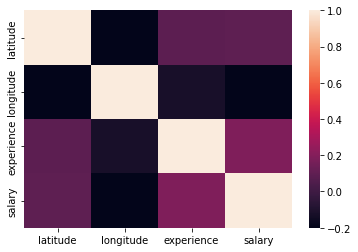

In [27]:
# Построим матрицу корреляции числовых признаков
plot = sns.heatmap(vacancies_copy.loc[:, ['latitude', 'longitude', 'experience', 'salary']].corr())
fig = plot.get_figure()
fig.savefig('heatmap.png')

In [28]:
# Стандартизируем числовые признаки
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
vacancies_copy[['experience', 'latitude', 'longitude']] = scaler.fit_transform(vacancies_copy[['experience', 'latitude', 'longitude']])

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer
# Кодируем навыки c помощью преобразования TF-IDF
tfidf = TfidfVectorizer(max_features=10) 
skills_encoded = tfidf.fit_transform(vacancies_copy['skills'].values.astype('U'))
skills_encoded = pd.DataFrame(skills_encoded.toarray(), columns=tfidf.get_feature_names()).iloc[:, 1:]

In [30]:
vacancies_copy = pd.concat([vacancies_copy, skills_encoded], axis=1)

In [31]:
vacancies_copy.drop('skills', axis=1, inplace=True)

In [32]:
'''Удаление выбросов'''
# Колонки, в которых ищем выбросы
cols = ['longitude', 'latitude', 'salary'] 
# Считаем квантили и межквартильный диапазон
Q1 = vacancies_copy[cols].quantile(0.25) 
Q3 = vacancies_copy[cols].quantile(0.75)
IQR = Q3 - Q1
# Возвращает логический массив строк со значением признака в допустимых пределах
condition = ~((vacancies_copy[cols] < (Q1 - 1.5 * IQR)) | (vacancies_copy[cols] > (Q3 + 1.5 * IQR))).any(axis=1)
# Отбираем строки соответствующие и не соответсвуюшие условию
vacancies_non_outs = vacancies_copy[condition]
vacancies_outs = vacancies_copy[~condition]

C:\Users\79279\AppData\Local\Temp/ipykernel_21772/2920826912.py:7: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  plt.legend((non_outs,outs), labels=['Non-outlier','Outlier'])


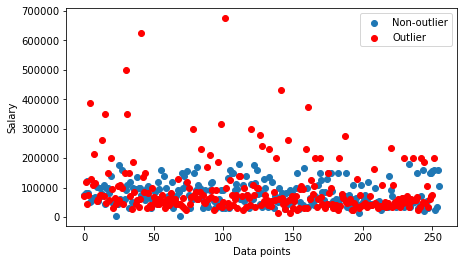

In [39]:
'''Показываем выбросы на графике ЗП'''
x_non_outs = range(len(vacancies_non_outs))
x_outs = range(len(vacancies_outs))
non_outs = plt.scatter(x_non_outs, vacancies_non_outs['salary'].values)
outs = plt.scatter(x_outs, vacancies_outs['salary'].values, color='r')
plt.legend((non_outs,outs), labels=['Non-outlier','Outlier'])
plt.xlabel('Data points')
plt.ylabel('Salary')
plt.show()

In [180]:
# Сохраняем предобработанный DataFrame в csv файл
vacancies_non_outs.to_csv('vacancies_prepared.csv')